<a href="https://colab.research.google.com/github/FajarRisk1/Project-Capstone-IL/blob/main/Project_Capstone_Bagus_Nur_Fajar_Riski_ACLED_ver2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
# Install required packages
!pip install squarify folium

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import squarify
from matplotlib import cm
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
import warnings
from wordcloud import WordCloud
from nltk.corpus import stopwords

# Set up seaborn style
sns.set_style('ticks')

# Initialize Plotly for offline plotting
py.init_notebook_mode(connected=True)

# Import the dataset
link = 'https://raw.githubusercontent.com/FajarRisk1/Project-Capstone-IL/main/2015-01-01-2019-01-31-South-Eastern_Asia-Indonesia.csv'
df = pd.read_csv(link, encoding="UTF-8")

In [31]:
# Display the first 5 rows of the dataset
df.head(5)

data_id  iso event_id_cnty  event_id_no_cnty       event_date  year  \
0  5590925  360        IDN520               520  31 January 2019  2019   
1  5590925  360        IDN520               520  31 January 2019  2019   
2  6301918  360        IDN526               526  31 January 2019  2019   
3  6301918  360        IDN526               526  31 January 2019  2019   
4  5590924  360        IDN519               519  30 January 2019  2019   

   time_precision                  event_type    sub_event_type  \
0               1                     Battles       Armed clash   
1               1                     Battles       Armed clash   
2               1  Violence against civilians            Attack   
3               1  Violence against civilians            Attack   
4               1                    Protests  Peaceful protest   

                                       actor1  ...     location  latitude  \
0  TPNPB: West Papua National Liberation Army  ...    Mapenduma   -4.3887   
1        Military Forces of Indonesia (2014-)  ...    Mapenduma   -4.3887   
2          Police Forces of Indonesia (2014-)  ...       Wamena   -4.0951   
3                          Civilians (Poland)  ...       Wamena   -4.0951   
4                      Protesters (Indonesia)  ...  Lebak Bulus   -6.3037   

   longitude geo_precision        source source_scale  \
0   138.2340             1  Jakarta Post     National   
1   138.2340             1  Jakarta Post     National   
2   138.9449             1   Pattaya One     Regional   
3   138.9449             1   Pattaya One     Regional   
4   106.7800             1  Jakarta Post     National   

                                               notes fatalities   timestamp  \
0  On January 31, 2019, in Mapenduma village (Ndu...          0  1563366749   
1  On January 31, 2019, in Mapenduma village (Ndu...          0  1563366749   
2  On 31 January 2019, a Polish man in the police...          0  1572403769   
3  On 31 January 2019, a Polish man in the police...          0  1572403769   
4  On January 30, 2019, in Lebak Bulus village of...          0  1563366749   

   iso3  
0   IDN  
1   IDN  
2   IDN  
3   IDN  
4   IDN  

[5 rows x 28 columns]

In [32]:
print(df.columns)
df = df[['actor1', 'country', 'event_date', 'event_type', 'fatalities','latitude', 'location',
       'longitude', 'notes', 'source', 'year']]
round((df.isnull().sum()/df.shape[0])*100,2)

Index(['data_id', 'iso', 'event_id_cnty', 'event_id_no_cnty', 'event_date',
       'year', 'time_precision', 'event_type', 'sub_event_type', 'actor1',
       'assoc_actor_1', 'inter1', 'interaction', 'region', 'country', 'admin1',
       'admin2', 'admin3', 'location', 'latitude', 'longitude',
       'geo_precision', 'source', 'source_scale', 'notes', 'fatalities',
       'timestamp', 'iso3'],
      dtype='object')


actor1        0.0
country       0.0
event_date    0.0
event_type    0.0
fatalities    0.0
latitude      0.0
location      0.0
longitude     0.0
notes         0.0
source        0.0
year          0.0
dtype: float64

In [33]:
print("Daftar kolom yang ada pada dataframe : ")
for col in df.columns:
  print(col)

Daftar kolom yang ada pada dataframe : 
actor1
country
event_date
event_type
fatalities
latitude
location
longitude
notes
source
year


## Penjelasan Masing-Masing Kolom

1. actor1 : Aktor bernama yang terlibat dalam kejadian tersebut
2. country : Self Explained
3. event_date : Tanggal kejadian Dicatat sebagai Hari / Bulan / Tahun.
4. event_type : Jenis/Tipe kejadian
5. fatalities : Jumlah atau perkiraan korban jiwa akibat kejadian. Hal ini sering kali berbeda di seluruh laporan
6. latitude : Garis lintang lokasi
7. location : Lokasi tempat kejadian berlangsung.
8. longitude : Garis bujur lokasi
9. notes : Deskripsi singkat tentang kejadian tersebut
10. source : Sumber yang digunakan membuat data ini
11. year : Tahun di mana kejadian terjadi.

In [34]:
# Function to plot distribution of each column
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if 1 < nunique[col] < 50]]
    nRow, nCol = df.shape
    columnNames = list(df)

    nGraphRow = (nCol + nGraphPerRow - 1) // nGraphPerRow

    plt.figure(num=None, figsize=(6 * nGraphPerRow, 8 * nGraphRow), dpi=80, facecolor='w', edgecolor='k')

    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]

        if not np.issubdtype(type(columnDf.iloc[0]), np.number):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()

        plt.ylabel('counts')
        plt.xticks(rotation=90)
        plt.title(f'{columnNames[i]} (column {i})')

    plt.tight_layout(pad=1.0, w_pad=1.0, h_pad=1.0)
    plt.show()

In [35]:
# Function to plot correlation matrix
def plotCorrelationMatrix(df, graphWidth):
    df = df.dropna('columns')
    df = df[[col for col in df if df[col].nunique() > 1]]
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum=1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix for {df.columns[0]}', fontsize=15)
    plt.show()

In [36]:
# Function to plot scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include=[np.number])
    df = df.dropna('columns')
    df = df[[col for col in df if df[col].nunique() > 1]]
    columnNames = list(df)
    if len(columnNames) > 10:
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*np.triu_indices_from(ax, k=1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()

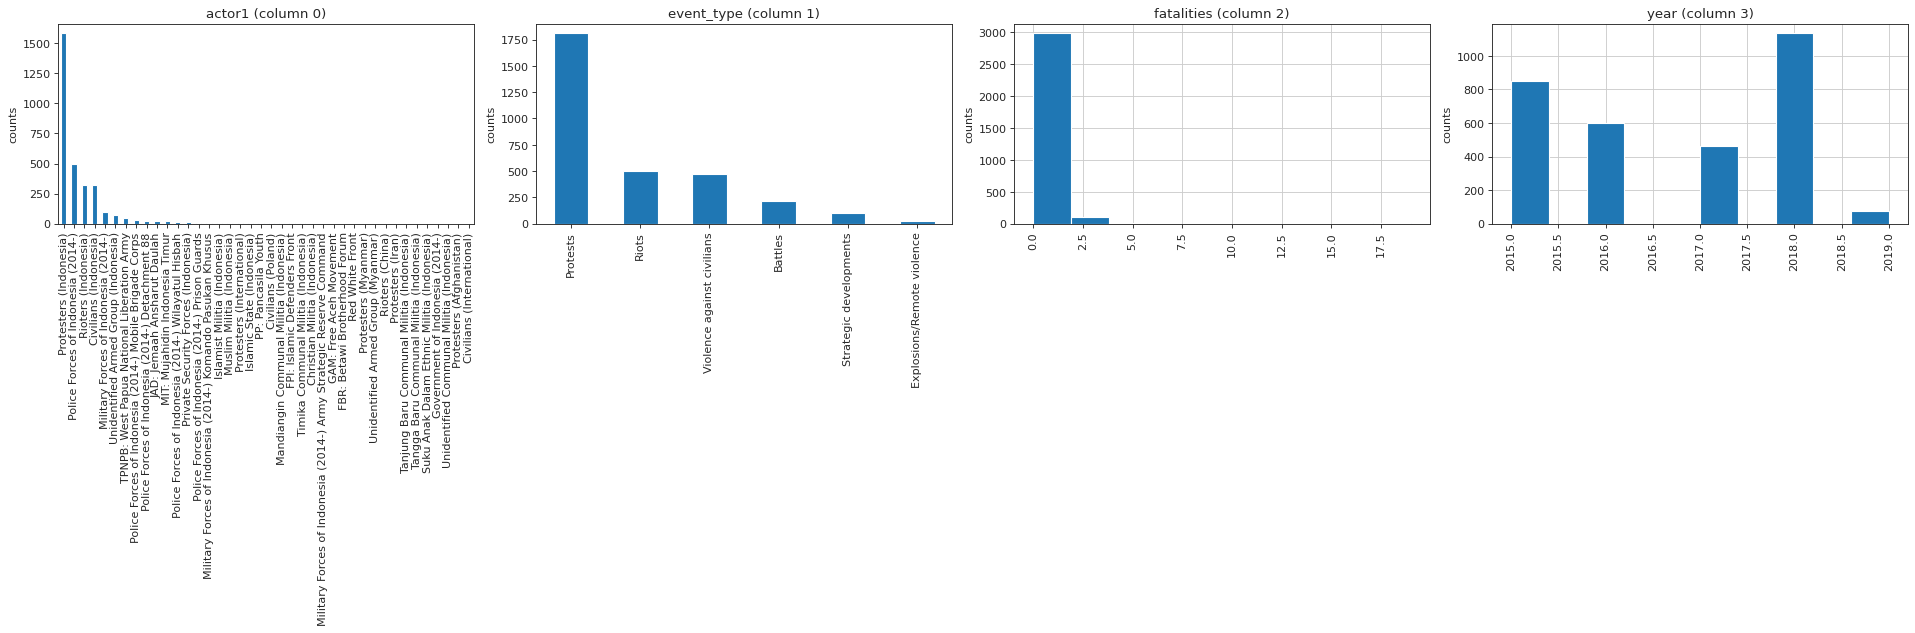

In [38]:
plotPerColumnDistribution(df, 10, 5)

<ipython-input-36-d7da383648c0>:4: FutureWarning:

In a future version of pandas all arguments of DataFrame.dropna will be keyword-only.



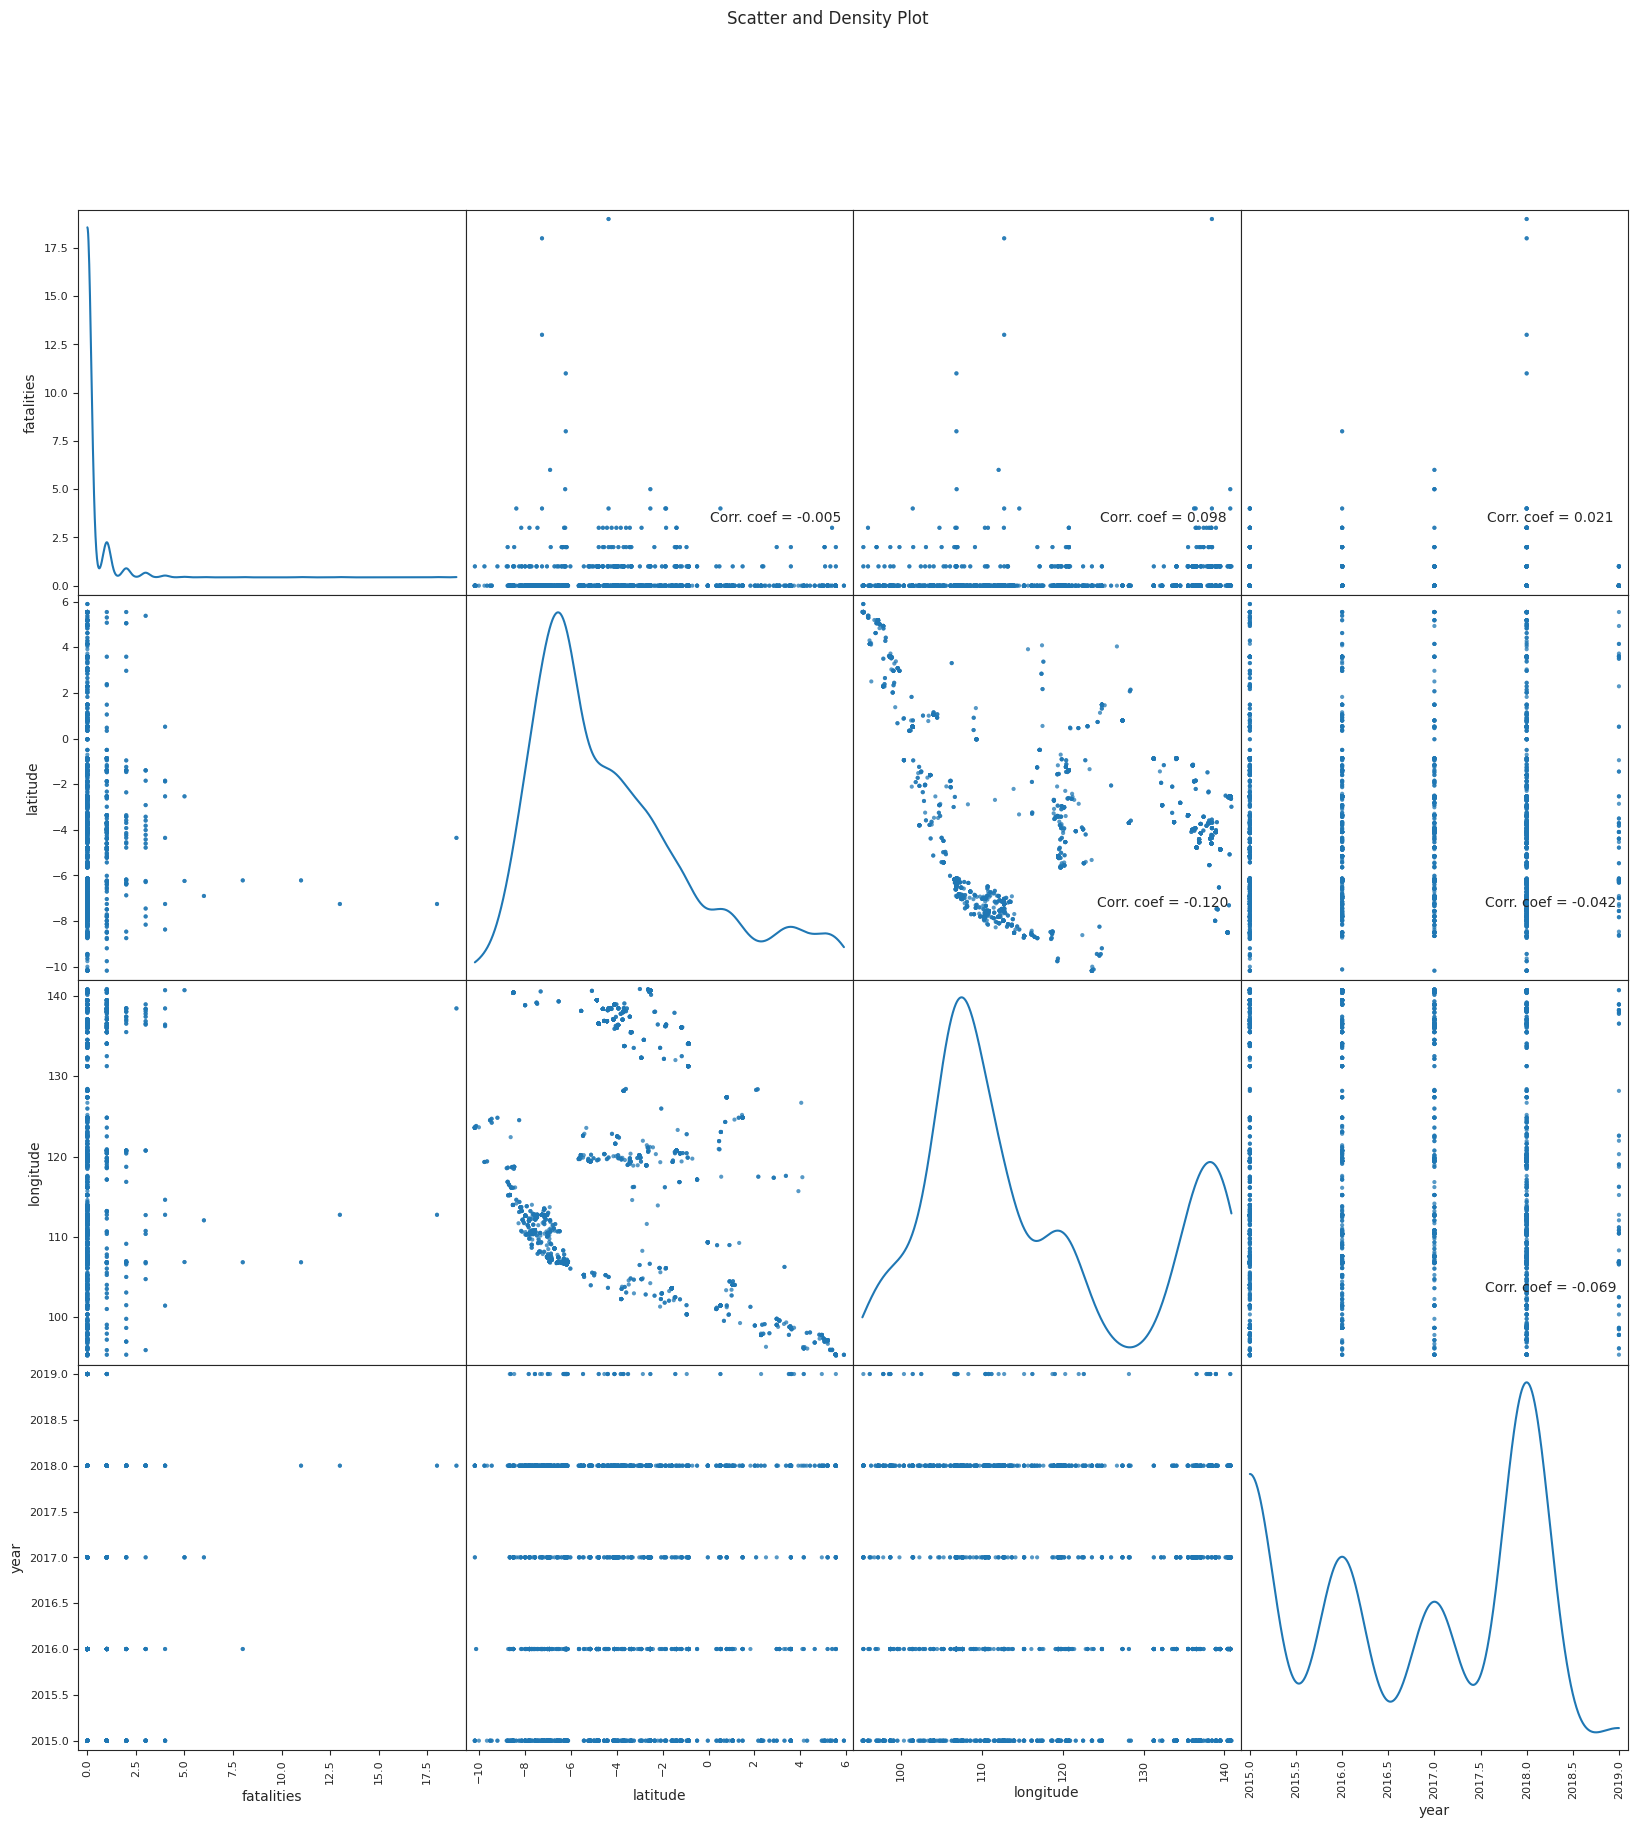

In [39]:
plotScatterMatrix(df, 20, 10)

In [40]:
map_indonesia = folium.Map(location=[-1.85, 118.04], zoom_start=5)

event_colors = {
    'Protests': 'blue',
    'Battles': 'red',
    'Riots': 'green',
    'Violence against civilians': 'orange',
    'Strategic developments': 'purple'
}

for index, row in df.iterrows():
    event_type = row['event_type']
    if event_type in event_colors:
        folium.Marker(
            location=[row['latitude'], row['longitude']],
            tooltip=row['country'],
            icon=folium.Icon(color=event_colors[event_type])
        ).add_to(map_indonesia)

map_indonesia

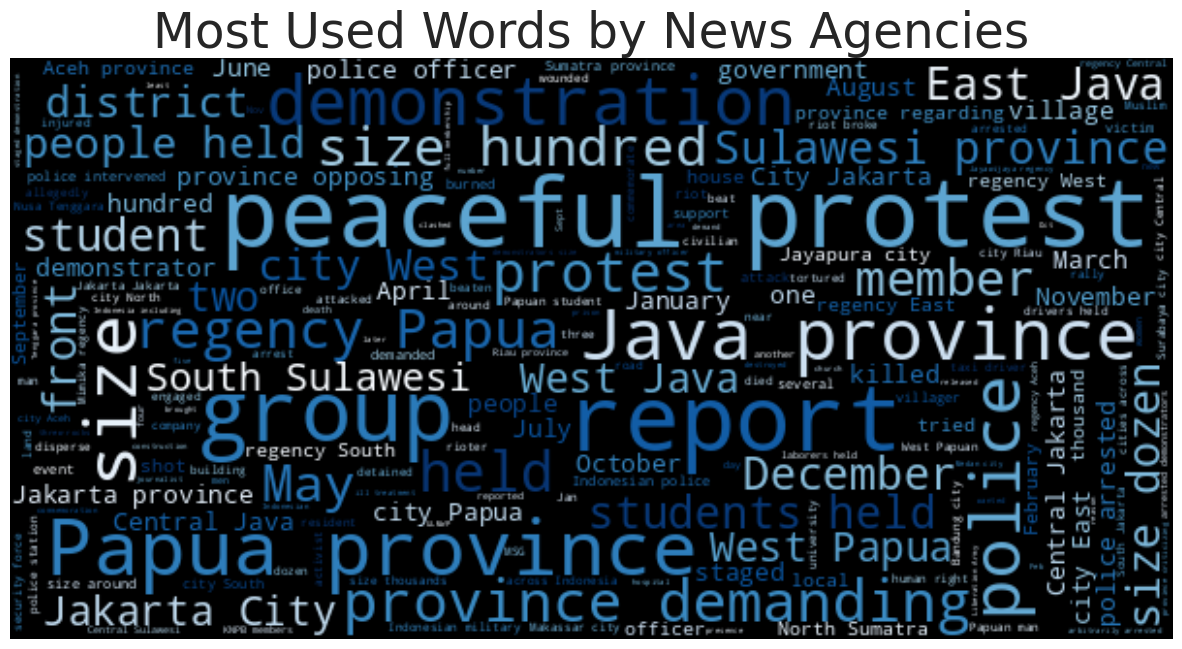

In [41]:
# Select relevant columns
df = df[['actor1', 'event_type', 'fatalities', 'latitude', 'longitude', 'year','notes']]

# Generate a word cloud from 'notes' column
wc = WordCloud(max_font_size=50, width=600, height=300, colormap='Blues')
wc.generate(' '.join(df['notes'].values))

plt.figure(figsize=(15, 8))
plt.imshow(wc, interpolation="bilinear")
plt.title("Most Used Words by News Agencies", fontsize=35)
plt.axis("off")
plt.show()

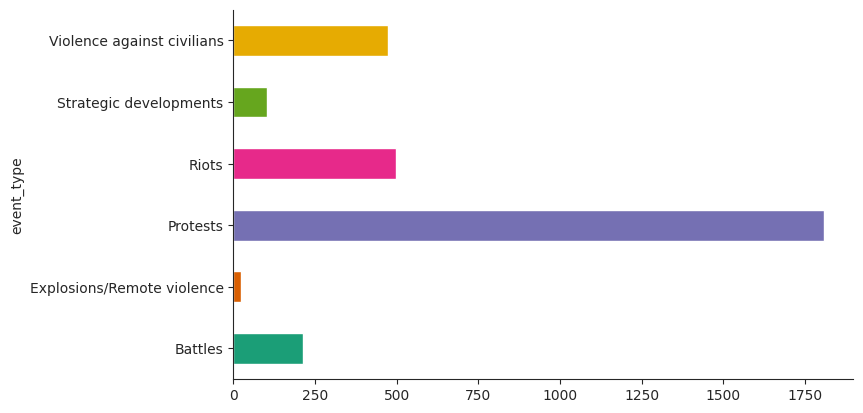

In [42]:
# Function to plot categorical histograms
def categorical_histogram(df, colname, figscale=1, mpl_palette_name='Dark2'):
    df.groupby(colname).size().plot(kind='barh', color=sns.color_palette(mpl_palette_name), figsize=(8 * figscale, 4.8 * figscale))
    plt.gca().spines[['top', 'right']].set_visible(False)

# Plot categorical histogram for 'event_type'
categorical_histogram(df, 'event_type')

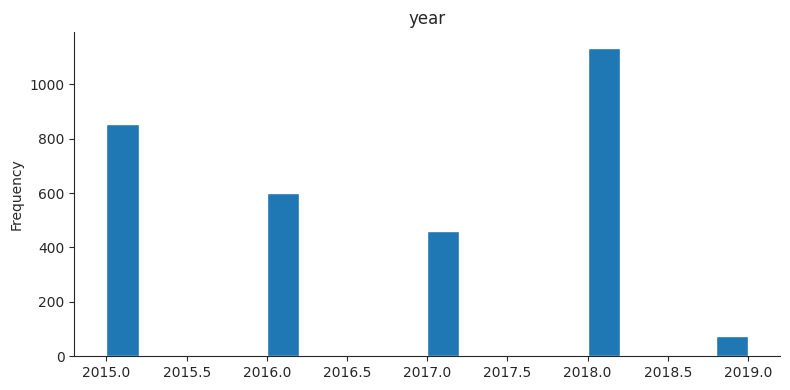

In [43]:
# Function to plot histograms
def histogram(df, colname, num_bins=20, figscale=1):
    df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8 * figscale, 4 * figscale))
    plt.gca().spines[['top', 'right']].set_visible(False)
    plt.tight_layout()

# Plot histogram for 'year' column
histogram(df, 'year')

In [44]:
df

actor1                  event_type  \
0     TPNPB: West Papua National Liberation Army                     Battles   
1           Military Forces of Indonesia (2014-)                     Battles   
2             Police Forces of Indonesia (2014-)  Violence against civilians   
3                             Civilians (Poland)  Violence against civilians   
4                         Protesters (Indonesia)                    Protests   
...                                          ...                         ...   
3116          Police Forces of Indonesia (2014-)                    Protests   
3117  TPNPB: West Papua National Liberation Army                     Battles   
3118        Military Forces of Indonesia (2014-)                     Battles   
3119                         Rioters (Indonesia)                       Riots   
3120                   Civilians (International)                       Riots   

      fatalities  latitude  longitude  year  \
0              0   -4.3887   138.2340  2019   
1              0   -4.3887   138.2340  2019   
2              0   -4.0951   138.9449  2019   
3              0   -4.0951   138.9449  2019   
4              0   -6.3037   106.7800  2019   
...          ...       ...        ...   ...   
3116           0   -6.2146   106.8450  2015   
3117           3   -4.4210   136.8588  2015   
3118           3   -4.4210   136.8588  2015   
3119           0    5.8925    95.3220  2015   
3120           0    5.8925    95.3220  2015   

                                                  notes  
0     On January 31, 2019, in Mapenduma village (Ndu...  
1     On January 31, 2019, in Mapenduma village (Ndu...  
2     On 31 January 2019, a Polish man in the police...  
3     On 31 January 2019, a Polish man in the police...  
4     On January 30, 2019, in Lebak Bulus village of...  
...                                                 ...  
3116  On 1 January 2015, there was a violent dispers...  
3117  On 1 January 2015, two second brigadier office...  
3118  On 1 January 2015, two second brigadier office...  
3119  On January 1, 2015, an unidentified Muslim gro...  
3120  On January 1, 2015, an unidentified Muslim gro...  

[3121 rows x 7 columns]

In [45]:
# Drop unnecessary columns
df = df.drop(columns=['actor1','notes',])

In [47]:
df

event_type  fatalities  latitude  longitude  year
0              0           0   -4.3887   138.2340  2019
1              0           0   -4.3887   138.2340  2019
2              5           0   -4.0951   138.9449  2019
3              5           0   -4.0951   138.9449  2019
4              2           0   -6.3037   106.7800  2019
...          ...         ...       ...        ...   ...
3116           2           0   -6.2146   106.8450  2015
3117           0           3   -4.4210   136.8588  2015
3118           0           3   -4.4210   136.8588  2015
3119           3           0    5.8925    95.3220  2015
3120           3           0    5.8925    95.3220  2015

[3121 rows x 5 columns]

In [46]:
# Encode the 'event_type' column
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df['event_type'] = label_encoder.fit_transform(df['event_type'])

X = df.drop(columns=['event_type'])
y = df['event_type']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Perform k-fold cross-validation
from sklearn.model_selection import KFold

n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

for fold, (train_index, test_index) in enumerate(kf.split(X)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

# Import and create an ensemble classifier
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC

decision_tree_model = DecisionTreeClassifier(random_state=42)
random_forest_model = RandomForestClassifier(n_estimators=100, random_state=42)
gradient_boosting_model = GradientBoostingClassifier(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42)
svm_model = SVC(probability=True, random_state=42)

ensemble_classifier = VotingClassifier(estimators=[
    ('Decision Tree', decision_tree_model),
    ('Random Forest', random_forest_model),
    ('Gradient Boosting', gradient_boosting_model),
    ('SVM', svm_model)
], voting='soft')

# Fit the ensemble classifier on the training data
ensemble_classifier.fit(X_train, y_train)

# Perform cross-validation to evaluate the model
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(ensemble_classifier, X_train, y_train, cv=5, scoring='accuracy')

for i, score in enumerate(cv_scores, start=1):
    accuracy_percent = score * 100
    print(f"Fold {i} - Accuracy: {accuracy_percent:.2f}%")

mean_accuracy = np.mean(cv_scores)
mean_accuracy_percent = mean_accuracy * 100
print(f"Rata-rata Akurasi: {mean_accuracy_percent:.2f}%")

# Make predictions on the test data
y_pred = ensemble_classifier.predict(X_test)

# Evaluate the model on the test data
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

accuracy = accuracy_score(y_test, y_pred)

print("Hasil Prediksi:")
print(y_pred)
print("\nAkurasi Prediksi: {:.2f}%".format(accuracy * 100))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

confusion = confusion_matrix(y_test, y_pred)
print("\nMatriks Keakuratan:\n")
print(confusion)

Fold 1 - Accuracy: 61.00%
Fold 2 - Accuracy: 61.60%
Fold 3 - Accuracy: 46.89%
Fold 4 - Accuracy: 54.31%
Fold 5 - Accuracy: 45.49%
Rata-rata Akurasi: 53.86%
Hasil Prediksi:
[0 2 3 2 4 2 3 3 3 0 2 4 0 2 2 2 2 2 2 5 5 2 2 5 3 2 5 3 2 2 3 5 2 2 2 0 2
 5 5 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 5 2 2 2 2 0 2 2 2 2 2 2 3 2 4 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 5 2 5 2 5 2 2 2 2 2 2 3 2 0 2 2 2 2 5 2 2 2 2 2
 2 2 2 2 2 3 3 2 3 0 5 5 2 2 2 2 2 2 5 3 0 4 3 5 0 5 2 2 2 2 2 2 2 5 3 2 0
 2 0 0 0 0 2 2 2 2 2 2 2 2 2 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3
 2 2 2 2 2 2 5 2 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 5 2 5 2 2
 2 2 2 3 2 5 2 2 2 5 2 2 2 3 2 2 2 2 2 5 5 2 2 2 2 2 2 2 2 2 2 4 2 2 2 2 5
 5 5 2 5 2 0 5 2 2 0 5 2 5 2 2 4 5 5 2 3 3 2 2 2 5 2 2 2 3 5 2 5 3 5 5 5 5
 2 2 2 1 1 1 5 2 2 2 2 2 0 5 2 2 2 5 5 2 5 2 2 2 2 2 2 2 5 2 2 2 2 5 2 2 0
 2 3 2 2 5 3 3 2 5 2 2 2 2 2 5 2 2 2 2 2 3 2 3 3 2 2 2 2 2 3 2 2 2 5 0 2 5
 2 2 5 3 5 2 2 2 2 3 2 3 2 2 3 3 2 0 2 2 5 2 2 2 2 2 5 2 2 2 2 2 2 2 2 5 2
 5 